In [ ]:
# The PhD Job Market in Industry: A Data-Driven Analysis Using Revelio Data
#### By Elliot Oh

# Data Loading and variables
# This notebook assumes that the following preprocessed tables already exist on disk:
# - `phd_careers.parquet`: Tidy panel of **all positions** held after PhD completion (including academic + non-academic).

# Key columns used:
# - `user_id` – individual identifier  
# - `phd_cohortyear` – PhD completion year  
# - `field` – field of study (e.g., Engineering, Economics, Biology)  
# - `rics_k50` – LinkedIn industry classification  
# - `role_k1500_v2` – occupation classification  
# - `company` – employer name  
# - `position_startdate`, `position_enddate` – position start and end dates


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

plt.style.use("default")

# -------------------------------------------------------------------
# Paths (adjust these to your local setup before running)
# -------------------------------------------------------------------
DATA_DIR = "C:/Users/elliotoh/Box/lodes_shared/revelio/"     # where your parquet files live
FIG_DIR = "C:/Users/elliotoh/Box/lodes_shared/revelio/figures/"   # where figures will be saved

# Create dirs if needed
import os
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------------------------------------------------------
# Load preprocessed data
# -------------------------------------------------------------------
postphd_positions = pd.read_parquet(
    os.path.join(DATA_DIR, "phd_careers.parquet")
)

fields_order = [
    'Engineering', 'Business', 'Biology', 'Chemistry', 'Statistics',
    'Physics', 'Economics', 'Education', 'Mathematics', 'Medicine',
    'Finance', 'Marketing', 'Accounting', 'Architecture',
    'Information Technology'
]

keep_cols = ['user_id','position_id','position_startdate', 'position_enddate', 'field','role_k1500_v2', 'rics_k50', 'title_raw','company_raw','phd_cohortyear']
postphd_positions = postphd_positions[keep_cols]
postphd_positions.head()


,user_id,position_id,position_startdate,position_enddate,field,role_k1500_v2,rics_k50,title_raw,company_raw,phd_cohortyear
0,1000185.0,-7594451154502111232.0,2001-09-01,2002-08-01,Engineering,research scientist,Research and Development,postdoc,National Energy Technology Laboratory,2001
1,1000185.0,5318191364723391488.0,2001-09-01,2002-08-01,Engineering,research scientist,Education Services,Postdoc,Carnegie Mellon University,2001
2,1000185.0,-7395923350840898560.0,2002-09-01,2015-01-01,Engineering,scientist,Engineering and Construction Services,Principal Scientist,Honeywell,2001
3,1001194.0,4870974300808686592.0,2003-09-01,2004-06-01,<NA>,writer,Education Services,Visiting Assistant Professor of Russian,Colby College,2003
4,1001194.0,3154500422710195200.0,2004-01-01,2006-01-01,<NA>,teacher,Education Services,Lecturer in Russian,Harvard University,2003


In [ ]:
# Distinguish academic employers.
academic_employers = ['University', 'College', 'Institute', 'National.*Laborator', 'Virginia Tech', '^UCLA', '^UCS[DF]', '^UC[DIL]', 
                      '^UC [A-z]+', 'UChicago', '^UConn', '^MIT', 'Research Center'
                      ]
k12_employers = ['Public Schools', 'School District', 'Schools', 'School System', 'High School']

# Distinguish faculty from post-docs and teaching positions and students.
postdoc_words = ['postdoc','Post-Doc', 'Post Doc', 'Postgraduate', 'Post-Grad', 'Post Grad', 'Visiting','Adjunct','Instructor','Lecturer','Teaching', 'Clinical .* Professor', 'Clinical .* Faculty']
faculty_words = ['Professor', 'Department Head', 'Faculty', 'Department Chair']
student_words = ['Research Assistant', 'Graduate Assistant', 'Teaching Assistant']

# postphd_positions = postphd_positions[(postphd_positions.company_raw.str.contains('|'.join(academic_employers), na=False, flags=re.IGNORECASE)) & \
#                                        (~postphd_positions.company_raw.str.contains('|'.join(k12_employers), na=False, flags=re.IGNORECASE)) & \
#                                        (~postphd_positions.title_raw.str.contains('|'.join(student_words), na=False, flags=re.IGNORECASE))
#                                         ]
postphd_positions['postdoc'] = (postphd_positions.title_raw.str.contains('|'.join(postdoc_words), na=False, flags=re.IGNORECASE).astype(int) )
postphd_positions['faculty'] = (~postphd_positions.title_raw.str.contains('|'.join(postdoc_words), na=False, flags=re.IGNORECASE) ) & (postphd_positions.title_raw.str.contains('|'.join(faculty_words), na=False, flags=re.IGNORECASE) ).astype(int)
postphd_positions['academia'] = (postphd_positions.company_raw.str.contains('|'.join(academic_employers), na=False, flags=re.IGNORECASE) ) & (~postphd_positions.company_raw.str.contains('|'.join(k12_employers), na=False, flags=re.IGNORECASE) ).astype(int)

# 13% of graduates hold faculty positions, 15% of graduates hold post-doc/teaching positions. 
print(postphd_positions[postphd_positions.faculty==1].shape[0]/postphd_positions.shape[0]) 
print(postphd_positions[postphd_positions.postdoc==1].shape[0]/postphd_positions.shape[0]) 


0.1281657114628306
0.15128883469094292


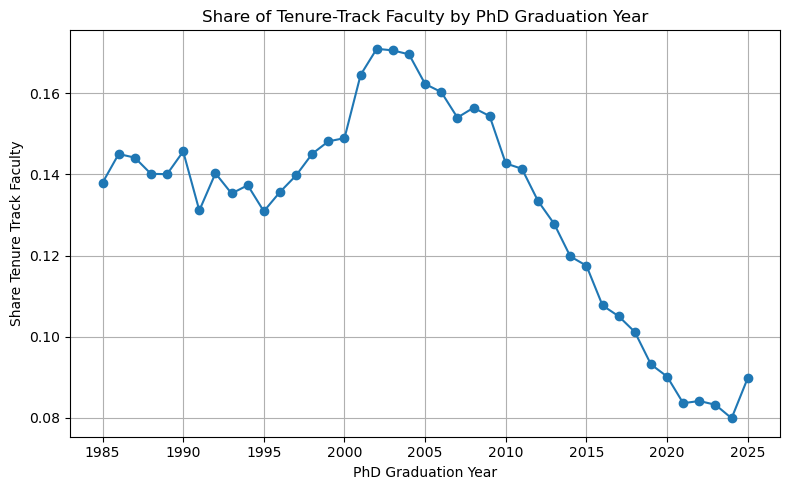

In [ ]:
# Plot share of tenure-track faculty out of academic jobs
cohort_col = "phd_cohortyear"   # <-- change this if your column name differs

faculty_share_by_cohort = (
    postphd_positions[postphd_positions[cohort_col]>=1985].groupby(cohort_col)['faculty']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
plt.plot(faculty_share_by_cohort[cohort_col],
         faculty_share_by_cohort['faculty'],
         marker='o')

plt.title("Share of Tenure-Track Faculty by PhD Graduation Year")
plt.xlabel("PhD Graduation Year")
plt.ylabel("Share Tenure Track Faculty")
plt.grid(True)
plt.tight_layout()
savepath = os.path.join(
    FIG_DIR, 
    "pct_tt_faculty_by_graduationyear.png"
    )
plt.savefig(savepath, dpi=300, bbox_inches="tight")

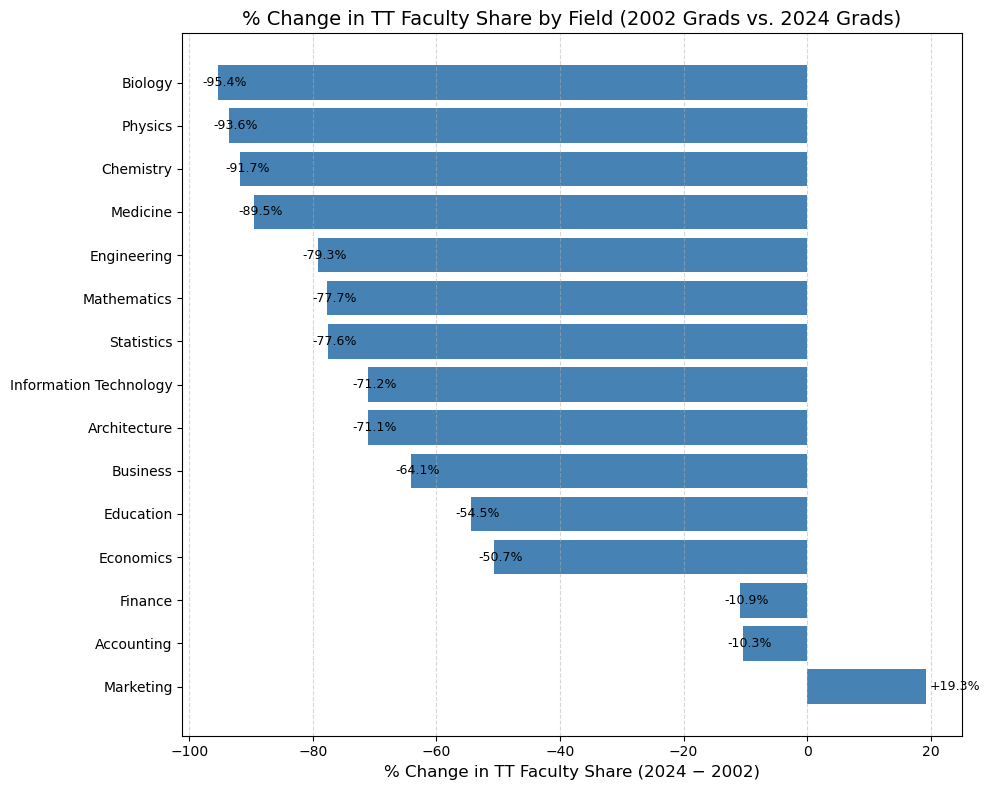

In [247]:
# Plot % change in share of graduates who ever held TT faculty between 2002 and 2024 graduates.  
cohort_col = "phd_cohortyear"

# --------------------------
# 1. Person-level ever TT indicator
# --------------------------
person_level = (
    postphd_positions
        .groupby(['user_id', cohort_col, 'field'], as_index=False)
        .agg({'faculty': 'max'})
)

# restrict to relevant years
person_level = person_level[(person_level[cohort_col] >= 1985)]

# --------------------------
# 2. TT share by field × cohort
# --------------------------
tt_by_field_cohort = (
    person_level
        .groupby(['field', cohort_col])['faculty']
        .mean()
        .reset_index()
)

# --------------------------
# 3. Extract 2002 and 2024 TT shares
# --------------------------
df_2002 = tt_by_field_cohort[tt_by_field_cohort[cohort_col] == 2002][['field', 'faculty']].rename(columns={'faculty': 'tt_2002'})
df_2024 = tt_by_field_cohort[tt_by_field_cohort[cohort_col] == 2024][['field', 'faculty']].rename(columns={'faculty': 'tt_2024'})

merged = pd.merge(df_2002, df_2024, on='field', how='inner')

# --------------------------
# 4. Compute signed % change (percentage points)
# --------------------------
merged['pct_change'] = (merged['tt_2024'] - merged['tt_2002']) / merged['tt_2002'] * 100

# Sort by largest decline (most negative first)
merged = merged.sort_values('pct_change', ascending=False)

# --------------------------
# 5. Plot horizontal bar graph
# --------------------------
plt.figure(figsize=(10, 8))
plt.barh(merged['field'], merged['pct_change'], color='steelblue')

plt.xlabel("% Change in TT Faculty Share (2024 − 2002)", fontsize=12)
plt.title("% Change in TT Faculty Share by Field (2002 Grads vs. 2024 Grads)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add value labels like -12.7% or +19.3%
for i, v in enumerate(merged['pct_change']):
    plt.text(v + (0.5 if v >= 0 else -2.5), i, f"{v:+.1f}%", 
             va='center', fontsize=9, color='black')

plt.tight_layout()

savepath = os.path.join(FIG_DIR, "signed_pct_change_tt_2002_2024_by_field.png")
plt.savefig(savepath, dpi=300, bbox_inches="tight")
plt.show()


C:\Users\elliotoh\AppData\Local\Temp\ipykernel_115472\441802921.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['share'] = top10['nworkers'] / top10['nworkers'].sum()


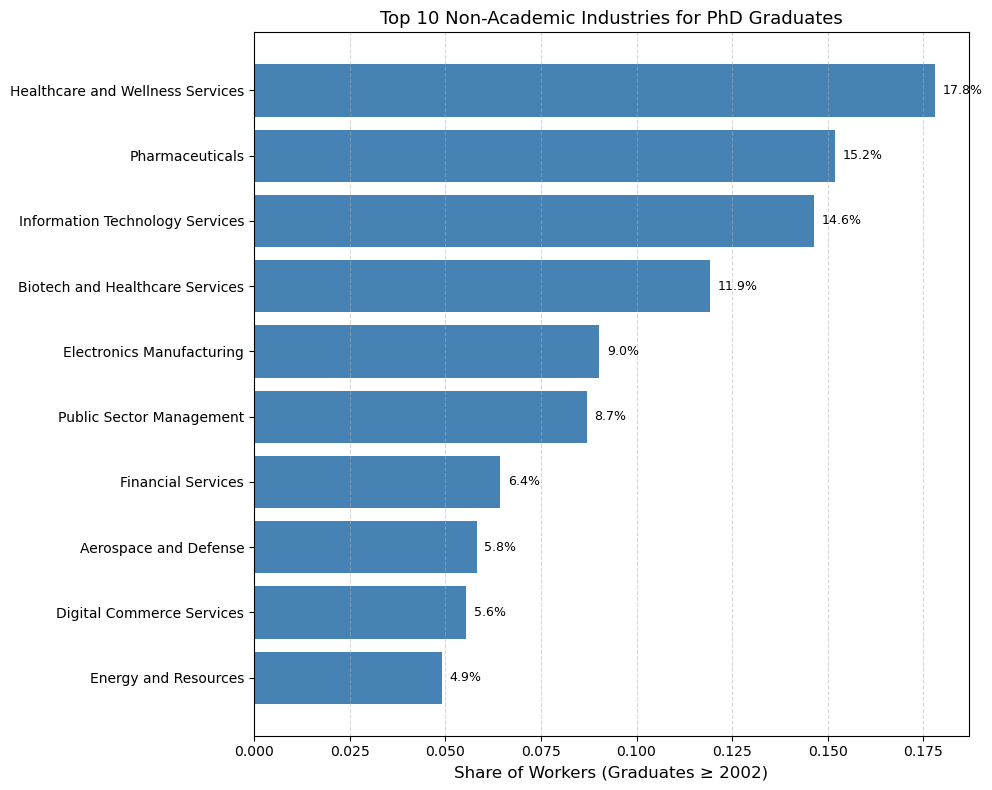

In [249]:
# Most popular industries

cohort_col = "phd_cohortyear"
industry_col = "rics_k50"

df = postphd_positions[postphd_positions[cohort_col] >= 2002].copy()
df = df[df['academia'] == 0]
exclude_ind = "Education Services|Research and Development"
df = df[~df[industry_col].str.contains(exclude_ind, na=False, flags=re.IGNORECASE)]

# --------------------------
# Compute industry shares
# --------------------------
industry_counts = (
    df[industry_col]
        .value_counts(dropna=False)
        .reset_index()
        .rename(columns={'count': 'nworkers'})
)

# Drop null industry names
industry_counts = industry_counts[industry_counts[industry_col].notnull()]

# Select top 10 industries
top10 = industry_counts.head(10)

# Compute shares
top10['share'] = top10['nworkers'] / top10['nworkers'].sum()

# Sort in ascending order for nicer horizontal bar plot
top10 = top10.sort_values('share', ascending=True)

# --------------------------
# Plot horizontal bar chart
# --------------------------
plt.figure(figsize=(10, 8))

plt.barh(top10[industry_col], top10['share'], color='steelblue')

plt.xlabel("Share of Workers (Graduates ≥ 2002)", fontsize=12)
plt.title("Top 10 Non-Academic Industries for PhD Graduates", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add % labels on bars
for i, v in enumerate(top10['share']):
    plt.text(v + 0.002, i, f"{v*100:.1f}%", va='center', fontsize=9)

plt.tight_layout()

savepath = os.path.join(FIG_DIR, "top10_industries_nonacademic_since2002.png")
plt.savefig(savepath, dpi=300, bbox_inches="tight")

plt.show()


C:\Users\elliotoh\AppData\Local\Temp\ipykernel_115472\2405425104.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['share'] = top10['nworkers'] / top10['nworkers'].sum()


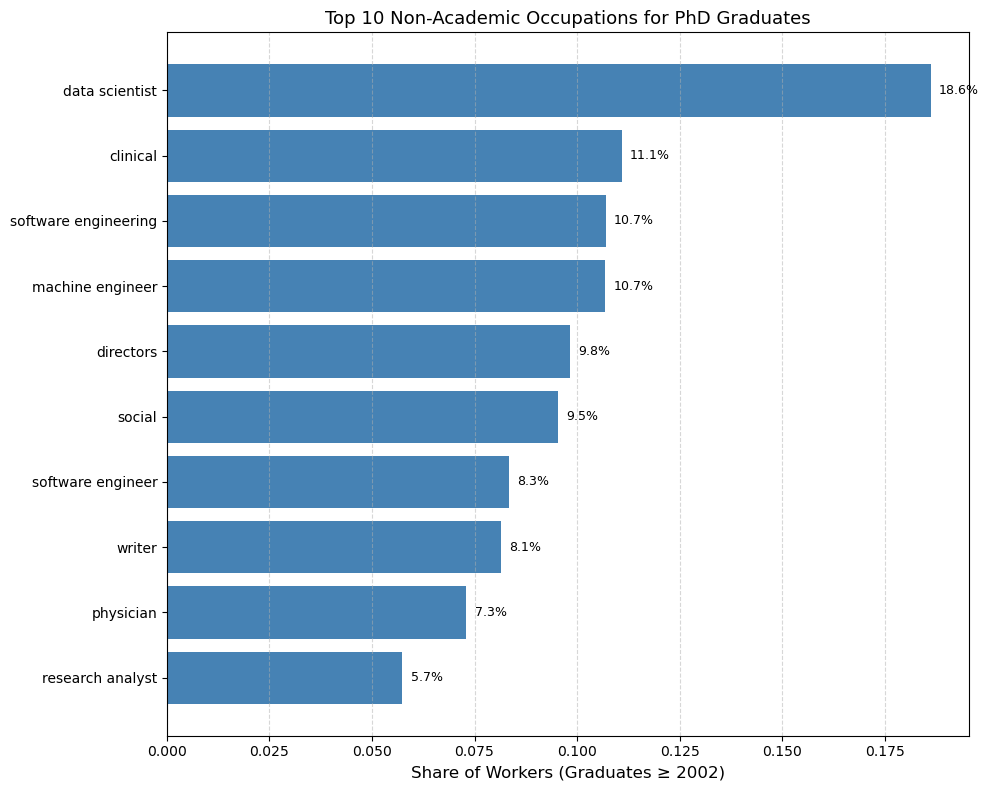

In [250]:
# Common occupations
cohort_col = "phd_cohortyear"
occupation_col = "role_k1500_v2"

exclude_occ = (
    "^professor$|^research$|^research scientist$|^researcher$|"
    "teach|lecturer|^scientist$|education|research engineer"
)

df = postphd_positions[postphd_positions[cohort_col] >= 2002].copy()

df = df[df['academia'] == 0]

# --------------------------
# Exclude "academic-like" occupations
# --------------------------
df = df[~df[occupation_col].str.contains(exclude_occ, na=False, flags=re.IGNORECASE)]

# --------------------------
# Compute occupation shares
# --------------------------
occupation_counts = (
    df[occupation_col]
        .value_counts(dropna=False)
        .reset_index()
        .rename(columns={'count': 'nworkers'})
)

occupation_counts = occupation_counts[occupation_counts[occupation_col].notnull()]

# Limit to top 10 occupations
top10 = occupation_counts.head(10)

# Compute shares
top10['share'] = top10['nworkers'] / top10['nworkers'].sum()

# Sort: largest → smallest
top10 = top10.sort_values('share', ascending=True)

# --------------------------
# 5. Plot: horizontal bar chart
# --------------------------
plt.figure(figsize=(10, 8))

plt.barh(top10[occupation_col], top10['share'], color='steelblue')

plt.xlabel("Share of Workers (Graduates ≥ 2002)", fontsize=12)
plt.title("Top 10 Non-Academic Occupations for PhD Graduates", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add % labels
for i, v in enumerate(top10['share']):
    plt.text(v + 0.002, i, f"{v*100:.1f}%", va='center', fontsize=9)

plt.tight_layout()

savepath = os.path.join(FIG_DIR, "top10_occupations_nonacademic_since2002.png")
plt.savefig(savepath, dpi=300, bbox_inches="tight")

plt.show()


Top 5 occupations: ['data scientist', 'clinical', 'software engineering', 'machine engineer', 'directors']


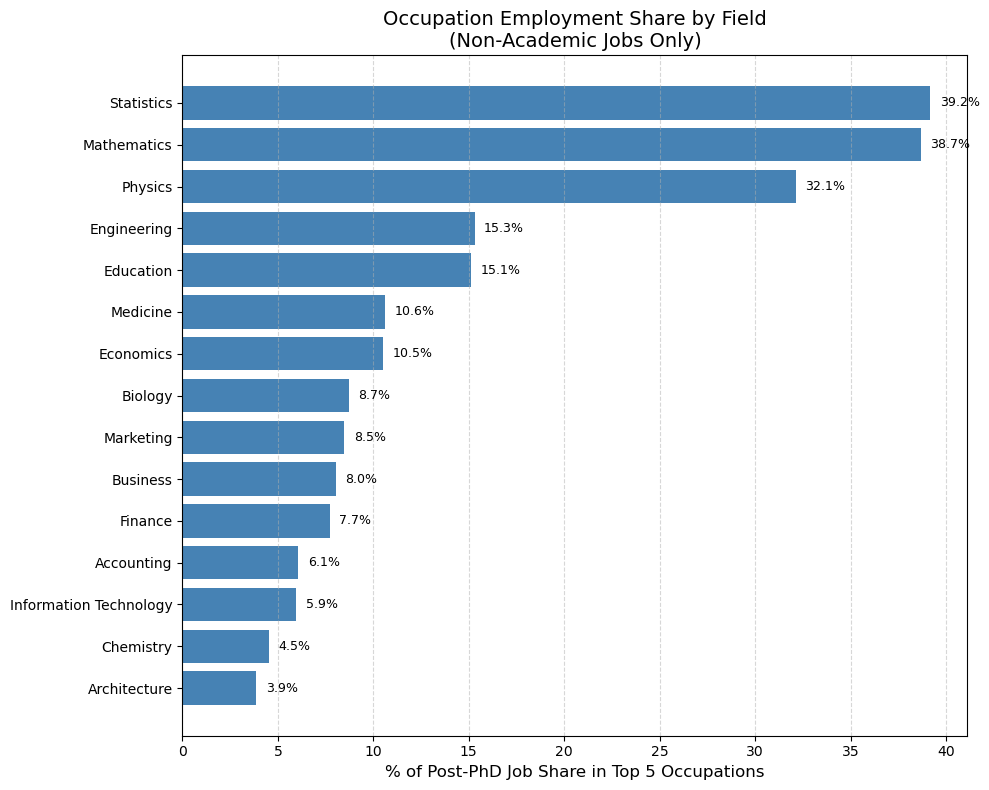

In [253]:
# Share of graduates that work in top 5 occupations by field (2002-2025)

cohort_col = "phd_cohortyear"
occupation_col = "role_k1500_v2"

# --------------------------
# 1. Filter to post-2002 PhD cohorts
# --------------------------
df = postphd_positions[postphd_positions[cohort_col] >= 2002].copy()

# --------------------------
# 2. Exclude academic employers (academia==1 means academic job)
# --------------------------
df = df[df['academia'] == 0].copy()
exclude_occ = (
    "^professor$|^research$|^research scientist$|^researcher$|"
    "teach|lecturer|^scientist$|education|research engineer"
)
df_nonacad = df[~df[occupation_col].str.contains(exclude_occ, na=False)].copy()



# --------------------------
# 3. Identify the top 5 occupations overall (non-academic only)
# --------------------------
top5_occupations = (
    df_nonacad[occupation_col]
        .value_counts()
        .head(5)
        .index
        .tolist()
)

print("Top 5 occupations:", top5_occupations)

# --------------------------
# 4. Compute occupation employment share by field (job-spell based)
# --------------------------
df_nonacad['top5'] = df_nonacad[occupation_col].isin(top5_occupations).astype(int)

# % of job spells in top 5 occupations by field
share_by_field = (
    df_nonacad
        .groupby('field')['top5']
        .mean()
        .reset_index()
)

share_by_field['share'] = share_by_field['top5'] * 100

# Sort so highest share is on top (lowest on bottom in horizontal plot)
share_by_field = share_by_field.sort_values('share', ascending=True)

# --------------------------
# 5. Plot: horizontal bar graph
# --------------------------
plt.figure(figsize=(10, 8))

plt.barh(share_by_field['field'], share_by_field['share'], color='steelblue')

plt.xlabel("% of Post-PhD Job Share in Top 5 Occupations", fontsize=12)
plt.title("Occupation Employment Share by Field\n(Non-Academic Jobs Only)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add % label on bars
for i, v in enumerate(share_by_field['share']):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=9)

plt.tight_layout()

savepath = os.path.join(FIG_DIR, "share_by_field_top5_occupations_jobspell_based.png")
plt.savefig(savepath, dpi=300, bbox_inches="tight")

plt.show()


In [254]:
# Calculate cosine similarity by all field pairs

cohort_col = "phd_cohortyear"
occupation_col = "role_k1500_v2"

# Occupation exclusion filter
exclude_occ = (
    "^professor$|^research$|^research scientist$|^researcher$|"
    "teach|lecturer|^scientist$|education|research engineer"
)

# --------------------------
# Filter to 2002+ cohorts and non-academic jobs
# --------------------------
df = postphd_positions[postphd_positions[cohort_col] >= 2002].copy()

# Remove academic employers
df = df[df["academia"] == 0]

# --------------------------
# Apply occupation exclusions
# --------------------------
df = df[~df[occupation_col].str.contains(exclude_occ, na=False, flags=re.IGNORECASE)]

# Drop missing occupations
df = df[df[occupation_col].notnull()]

# --------------------------
# Construct field × occupation matrix
# --------------------------
pivot_occ = (
    df.groupby(["field", occupation_col])
      .size()
      .reset_index(name="count")
      .pivot(index="field", columns=occupation_col, values="count")
      .fillna(0)
)

# Normalize rows → Convert to occupation share vectors
pivot_norm_occ = pivot_occ.div(pivot_occ.sum(axis=1), axis=0)

# --------------------------
# Compute pairwise cosine similarity
# --------------------------
similarity_occ = pd.DataFrame(
    cosine_similarity(pivot_norm_occ),
    index=pivot_norm_occ.index,
    columns=pivot_norm_occ.index
)

similarity_occ


field,Accounting,Architecture,Biology,Business,Chemistry,Economics,Education,Engineering,Finance,Information Technology,Marketing,Mathematics,Medicine,Physics,Statistics
field,,,,,,,,,,,,,,,
Accounting,1.000000,0.050977,0.119724,0.471714,0.060326,0.575241,0.254733,0.074065,0.593689,0.128583,0.332380,0.101044,0.055447,0.094372,0.090036
Architecture,0.050977,1.000000,0.059508,0.145270,0.027568,0.024370,0.118012,0.069539,0.040005,0.084727,0.117259,0.035249,0.025512,0.036931,0.019099
Biology,0.119724,0.059508,1.000000,0.325272,0.409647,0.149936,0.261173,0.268452,0.140525,0.187299,0.274074,0.287286,0.599065,0.351042,0.273634
Business,0.471714,0.145270,0.325272,1.000000,0.147933,0.252043,0.756931,0.215647,0.378217,0.427944,0.631870,0.193622,0.223066,0.214785,0.173375
Chemistry,0.060326,0.027568,0.409647,0.147933,1.000000,0.070838,0.086872,0.285186,0.076961,0.115388,0.122867,0.158663,0.127304,0.211720,0.124674
Economics,0.575241,0.024370,0.149936,0.252043,0.070838,1.000000,0.133627,0.121303,0.829369,0.082706,0.318730,0.285120,0.039829,0.257255,0.296536
Education,0.254733,0.118012,0.261173,0.756931,0.086872,0.133627,1.000000,0.082921,0.196049,0.218528,0.413811,0.059130,0.306042,0.074082,0.057835
Engineering,0.074065,0.069539,0.268452,0.215647,0.285186,0.121303,0.082921,1.000000,0.125276,0.444436,0.179738,0.613524,0.069872,0.693335,0.360991
Finance,0.593689,0.040005,0.140525,0.378217,0.076961,0.829369,0.196049,0.125276,1.000000,0.123265,0.372797,0.355489,0.043918,0.264169,0.270225


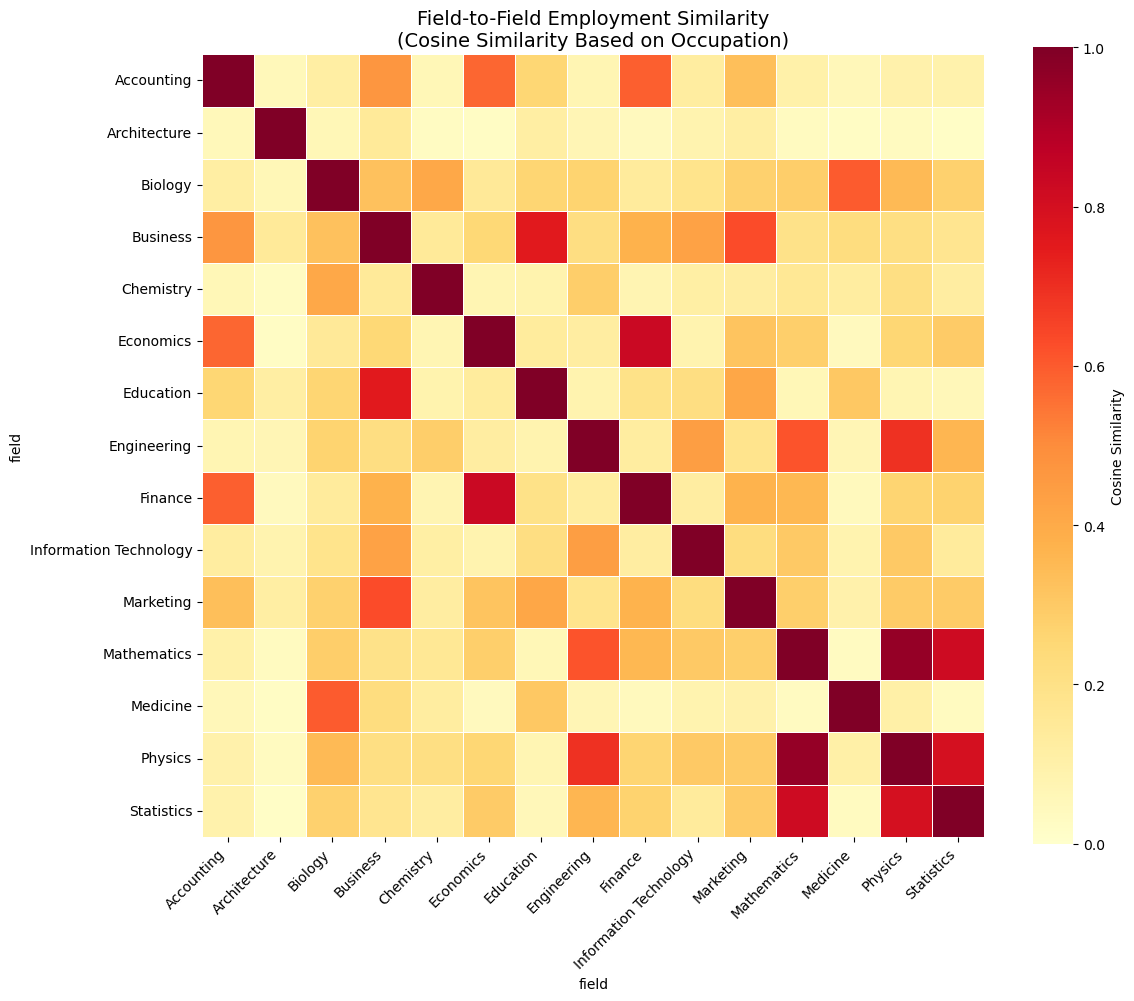

In [256]:
# --------------------------
# Heatmap of FieldXField similarity matrix
# --------------------------

plt.figure(figsize=(12, 10))

# Red = high similarity, Yellow = low similarity
cmap = sns.color_palette("YlOrRd", as_cmap=True)

sns.heatmap(
    similarity_occ,
    cmap=cmap,
    vmin=0, vmax=1,
    square=True,
    annot=False,       # set True if you want numeric values inside cells
    linewidths=0.5,
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title("Field-to-Field Employment Similarity\n(Cosine Similarity Based on Occupation)",
          fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()

savepath = os.path.join(FIG_DIR, "field_similarity_heatmap_occ.png")
plt.savefig(savepath, dpi=300, bbox_inches="tight")
plt.show()


In [257]:
# Compute occupations where field is overrepresented
def compute_field_advantage_simple(
    df,
    field_col="field",
    occupation_col="role_k1500_v2",
    exclude_occ_regex=None,
    exclude_academia_col="academia",
    min_overall_count=50,
    min_field_count=10,
    top_n=3
):
    """
    Compute top-N occupations where each field is most over-represented,
    using simple filtering and no smoothing.
    """

    # -----------------------------
    # 1. Exclude academic employers
    # -----------------------------
    df = df[df[exclude_academia_col] == 0].copy()

    # -----------------------------
    # 2. Exclude academic-like occupations
    # -----------------------------
    if exclude_occ_regex is not None:
        df = df[~df[occupation_col]
                .str.contains(exclude_occ_regex, na=False, case=False, regex=True)]

    df = df[df[occupation_col].notna()].copy()

    # -----------------------------
    # 3. Compute counts
    # -----------------------------
    df.columns

    field_occ = df.groupby([field_col, occupation_col]).size().rename("field_count")
    field_totals = field_occ.groupby(level=0).sum().rename("field_total")

    overall_occ = df.groupby(occupation_col).size().rename("overall_count")
    overall_total = overall_occ.sum()

    p_field_occ = (field_occ / field_totals).rename("p_field_occ")
    p_overall_occ = (overall_occ / overall_total).rename("p_overall_occ")

    # -----------------------------
    # 4. Merge all data into one table
    # -----------------------------
    merged = (
        p_field_occ.reset_index()
        .merge(field_occ.reset_index(), on=[field_col, occupation_col])   # field_count
        .merge(overall_occ.reset_index(), on=occupation_col)              # overall_count
        .merge(p_overall_occ.reset_index(), on=occupation_col)            # p_overall_occ
        .merge(field_totals.reset_index(), on=field_col)                  # field_total
    )

    # -----------------------------
    # 5. Compute over-index
    # -----------------------------
    merged["over_index"] = merged["p_field_occ"] / merged["p_overall_occ"]

    # -----------------------------
    # 6. Apply filters
    # -----------------------------
    filtered = merged[
        (merged["overall_count"] >= min_overall_count) &
        (merged["field_count"] >= min_field_count)
    ]

    # -----------------------------
    # 7. Select top-N per field
    # -----------------------------
    topn = (
        filtered
        .sort_values(["field", "over_index"], ascending=[True, False])
        .groupby(field_col)
        .head(top_n)
    )

    return(topn[
        [field_col, occupation_col, "over_index",
            "field_count", "overall_count", "p_field_occ", "p_overall_occ"]
    ]
    )

In [258]:
exclude_occ_regex = (
"^professor$|^research$|^research scientist$|^researcher$|"
"teach|lecturer|^scientist$|education|research engineer"
)

compute_field_advantage_simple(
    df=postphd_positions[postphd_positions["phd_cohortyear"] >= 2002],
    field_col="field",
    occupation_col="role_k1500_v2",
    exclude_occ_regex=exclude_occ_regex,
    exclude_academia_col="academia",
    min_overall_count=50,
    min_field_count=30,
    top_n=3)


,field,role_k1500_v2,over_index,field_count,overall_count,p_field_occ,p_overall_occ
211,Accounting,tax accountant,189.726851,31,155,0.034254,0.000181
3,Accounting,accounting,86.958140,33,360,0.036464,0.000419
101,Accounting,financial officer,44.315761,32,685,0.035359,0.000798
369,Architecture,project architect,190.425428,45,117,0.025952,0.000136
229,Architecture,architect,173.250356,471,1346,0.271626,0.001568
230,Architecture,architecture,166.809945,94,279,0.054210,0.000325
956,Biology,medical writer,6.336146,1522,6431,0.047463,0.007491
1289,Biology,technical support,6.226165,30,129,0.000936,0.000150
1118,Biology,research technician,6.203566,1679,7246,0.052359,0.008440
1806,Business,finance controller,10.690667,39,65,0.000809,0.000076
